In [1]:
from biquad import BiquadFilter
from plot import plot_signals
import numpy as np
import scipy.io.wavfile as wav
import time
import cmath as math
from pynq import allocate

# First, test software implementation

In [2]:
def apply_biquad_filter(wav, sampling_rate):
    # Initialize the filter
    center_freq = 1000
    A = 2
    Q = 0.5

    W0 = (2*3.14 * center_freq) / sampling_rate
    S  = math.sin(W0)
    alpha = S / (2*Q)

    b0 =  1 - alpha*A
    b1 = -2 * math.cos(W0)
    b2 =  1 - alpha*A
    a0 =  1 + alpha/A
    a1 = -2 * math.cos(W0)
    a2 =  1 - alpha/A

    b0 /= a0
    b1 /= a0
    b2 /= a0
    a1 /= a0
    a2 /= a0

    print(f"{b0} {b1} {b2} {a0} {a1} {a2}")

    #b0, b1, b2, a1, a2 = 0.2, 2, 0.5, -0.2, 0.5
    filter = BiquadFilter(b0, b1, b2, a1, a2)

    # Process the data through the filter
    return np.array([filter.process_sample(x) for x in wav])

In [4]:
def remove_offset(wav):
    # Convert data to float, normalize, and remove DC offset
    if wav.ndim > 1:  # if stereo, take only the first channel
        wav = wav[:, 0]
    wav = wav.astype(np.float32)
    wav -= np.mean(wav)  # Removing DC offset by subtracting the mean
    return wav

In [5]:
def output_wav(filtered_data, output_filename, sample_rate):
    filtered_data_int16 = np.int16(filtered_data / np.max(np.abs(filtered_data)) * 32767)

    # Write the filtered signal to a new WAV file
    wav.write(output_filename, sample_rate, filtered_data_int16)

    print(f"Filtered signal written to {output_filename}")

In [6]:
input_filename = 'hal_9000.wav'
output_filename = 'output_filtered.wav'

# Read the WAV file
sample_rate, data = wav.read(input_filename)

data = remove_offset(data)

(-0.061918403883710935+0j) (-1.326517478008766+0j) (-0.061918403883710935+0j) (1.2696537331605744+0j) (-1.326517478008766+0j) (0.5752326384465157+0j)
Elapsed Time:	9.373687505722046
Filtered signal written to output_filtered.wav


/tmp/ipykernel_6541/1518303373.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  filtered_data_int16 = np.int16(filtered_data / np.max(np.abs(filtered_data)) * 32767)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


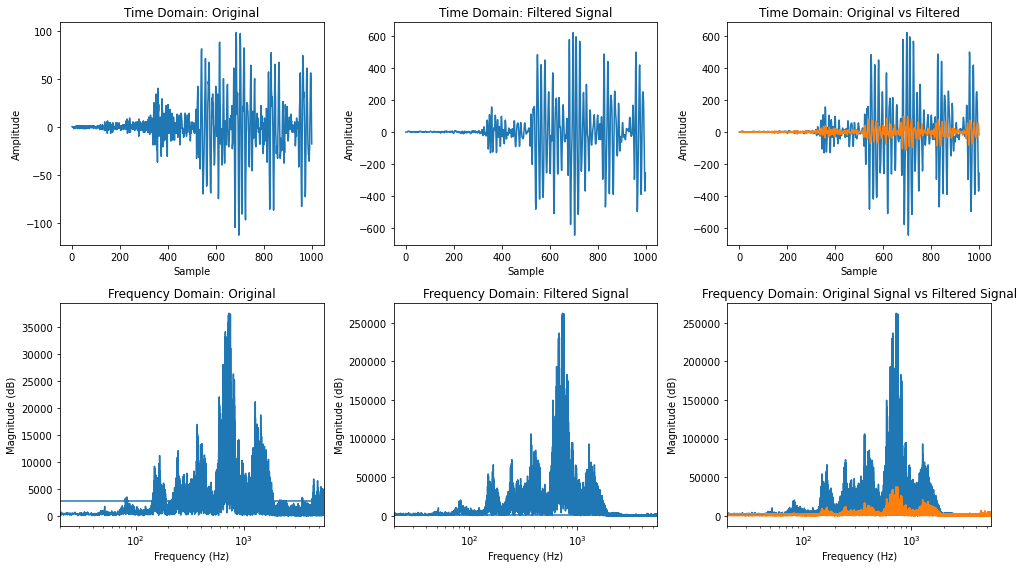

In [7]:

# Apply the filter to the input file
start = time.time()
filtered_data = apply_biquad_filter(data, sample_rate)
end = time.time()

print(f'Elapsed Time:\t{end-start}')

output_wav(filtered_data, output_filename, sample_rate)

plot_signals(data, filtered_data, sample_rate)



# Next, test hardware implementation

In [8]:
from pynq import Overlay

biquad_overlay = Overlay('/home/xilinx/overlays/echoeqv03/echoeqv03.bit')
biquad_overlay?

In [9]:
# Resize data to play nice with dma buffer sizes
SIZE_OF_BUFFER = 500
print(len(data))

current_length = data.size
# Calculate the remainder when the current length is divided by the buffer size
remainder = current_length % SIZE_OF_BUFFER
# If remainder is not zero, calculate the size needed to make length divisible by buffer size
if remainder != 0:
    new_length = current_length + (SIZE_OF_BUFFER - remainder)
else:
    new_length = current_length  # No resizing needed if already divisible

# Create a new array with the new length, filled with zeros
new_arr = np.zeros(new_length, dtype=data.dtype)
# Copy the original data to the new array
new_arr[:current_length] = data

data = new_arr
print(len(data))

55808
56000


In [28]:
# Calculate new coefficients from center frequency
biquad_overlay.axi_bram_ctrl_1.write(0, 0b100000000000000)
biquad_overlay.axi_bram_ctrl_1.write(4, 0)
biquad_overlay.axi_bram_ctrl_1.write(8, 0)
biquad_overlay.axi_bram_ctrl_1.write(12, 0)
biquad_overlay.axi_bram_ctrl_1.write(16, 0)

In [29]:

dma = biquad_overlay.axi_dma_0
input_buffer = allocate(shape=(SIZE_OF_BUFFER,), dtype=np.int32)
output_buffer = allocate(shape=(SIZE_OF_BUFFER,), dtype=np.int32)

filtered_data = np.zeros(len(data))


Elapsed Time:	0.14046788215637207
Filtered signal written to output_filtered.wav


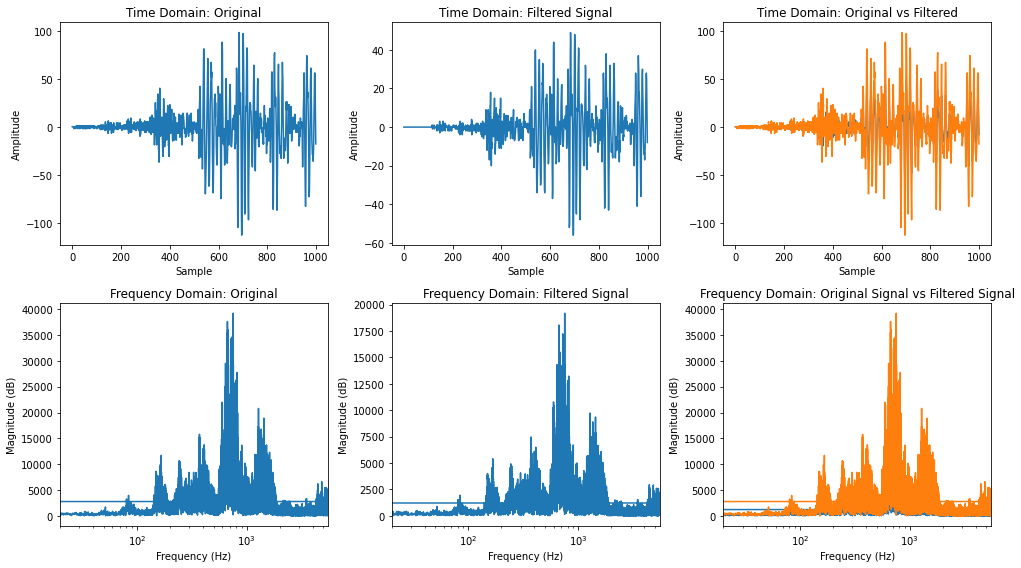

In [30]:
i = 0

start = time.time()

for i in range(int(len(data) / SIZE_OF_BUFFER)):
        starting_idx = (i * SIZE_OF_BUFFER)
        input_buffer[:] = data[starting_idx:starting_idx + SIZE_OF_BUFFER]
        dma.sendchannel.transfer(input_buffer)
        dma.recvchannel.transfer(output_buffer)
        dma.sendchannel.wait()
        dma.recvchannel.wait()
        filtered_data[starting_idx:starting_idx + SIZE_OF_BUFFER] = output_buffer[:]
        i += SIZE_OF_BUFFER
end = time.time()

print(f'Elapsed Time:\t{end-start}')

output_wav(filtered_data, output_filename, sample_rate)

plot_signals(data, filtered_data, sample_rate)